In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map

# Introduction

In this report we're going to take a look at a small sample of the data from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of news reporting on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. 

For our sample of the GDELT data, we're going to take a look at the data available for the USA's presidential election days in 2008 and 2016: November 4th, 2008 and November 8th, 2016. We're generally here to survey the data. To guide our exploration, we seek to determine whether the average tone of media coverage was significantly different between the two election days. 

# Data Preparation

We first load in row limited samples of our two datasets. Our first step is to quickly verify everything looks normal.

In [2]:
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

df_2008_l = pd.read_csv(data_2008, sep='\t', nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', nrows=1000)

df_2016_l.head()

,596760615,20151109,201511,2015,2015.8466,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,967537,3.1,"Times Square, New York, United States.1",US.1,USNY.1,40.757.1,-73.986.1,967537.1,20161108,http://www.wsaw.com/content/news/Candidates-make-final-stops-on-Election-Day-eve-400321591.html
0,596760616,20151109,201511,2015,2015.8466,NaN,NaN,NaN,NaN,NaN,...,1662328,3,"Los Angeles, California, United States",US,USCA,34.0522,-118.2440,1662328,20161108,http://www.rollingstone.com/culture/news/jinx-...
1,596760617,20151109,201511,2015,2015.8466,AUT,AUSTRIAN,AUT,NaN,NaN,...,AU,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
2,596760618,20151109,201511,2015,2015.8466,AUT,AUSTRIAN,AUT,NaN,NaN,...,IR,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
3,596760619,20151109,201511,2015,2015.8466,AUTJUD,AUSTRIAN,AUT,NaN,NaN,...,AU,1,Austria,AU,AU,47.3333,13.3333,AU,20161108,https://www.scmagazine.com/swiss-investigators...
4,596760620,20151109,201511,2015,2015.8466,BWAELIGOV,FESTUS MOGAE,BWA,NaN,NaN,...,-1397372,4,"Gaborone, South East, Botswana",BC,BC09,-24.6464,25.9119,-1397372,20161108,http://www.albuquerqueexpress.com/index.php/si...


## Fixing Column Names

We already have a problem! The CSV's do not provide a header. With the documentation, we can determine that there are 58 columns for data after April 2013, and 57 before. With this, we can reload our dataframes properly.

In [3]:
df_2008_l = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, nrows=1000)

## Improving Memory Consumption and Performance

By default, Pandas makes safe but space inefficient choices for data types by always defaulting to int64/float64/object. We can improve memory use and load performance when making a dataframe out of the full CSV's by omitting any extra data that we are not interested in for our current analysis and, more importantly, by determining optimized data types for each column.

For the former case, we note by looking at the [Data Format Codebook](http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf) that there are multiple columns which encode dates in different ways. There are also DATEADDED and SOURCEURL fields, describing the date the record was added to the data set and the source of the news respectively, which will not have any bearing on our analysis. Thus we omit these columns. 

Next we look into appropriate data types for our columns. For this analysis we follow the lead of [Using pandas with large data](https://www.dataquest.io/blog/pandas-big-data/). We first filter our dataframes for particular classes of types: integers/floats/objects. For the purposes of this report, we only follow the work on a single dataframe but the analysis has been applied to both.

## Optimizing Number Columns

In [4]:
df_2008_l_int = df_2008_l.select_dtypes(include=['int64'])
df_2008_l_int.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'NumMentions', 'NumSources', 'NumArticles', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FeatureID', 'DATEADDED'],
      dtype='object')

We can then attempt to apply "downcasting" to these integer columns. That is, we can use a method of Pandas, to_numeric, to find the smallest size integer type which will support all values of the columns. The available types are int8, int16, int32 and int64, as well as unsigned variants (only positive numbers) uint8, uint16, uint32 and uint64. The numbers at the end of each type indicate the number of bits consumed in order to represent the data type, and thus smaller numbers correspond with less memory consumption. 

The data's documentation also reaveals that all of these columns will have positive values. (We also find that some of these fields are not best represented as integers for the purposes of analysis, more on this below.) We now apply the downcasting into unsigned integer data types and show a comparison of memory usage.

In [5]:
converted_int = df_2008_l_int.apply(pd.to_numeric,downcast='unsigned')

num_before, str_before = mem_usage(df_2008_l_int)
num_after, str_after = mem_usage(converted_int)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  0.14 MB
After downcast:  0.04 MB
Percent Decrease 0.7287617990005553


We see a 72% decrease in memory usage in this example. A similar process to the one we just applied to int columns can be used for float columns. 

## Optimizing Object Columns

Optimizing object columns is more involved. Generally an object column is made up of string values. In some cases, there is nothing we can do to minimize memory consumption. This generally applies when there are many unique string values in a column. However, if there are sufficient repeats, we can use a different numpy data type known as a category. 

This data type leverages a map-like structure to translate repeated strings into less memory intensive integers, and then covertly replaces the repeated values with these integers. The original values are then recoverable in this case by following the mapping. This can result in huge increases in memory efficiency. For a first pass, we apply a methodology present in our source for this memory optimization which replaces an object column with category if less than 50% of the values are unique.

In [6]:
df_2008_l_obj = df_2008_l.select_dtypes(include=['object'])
df_2008_l_obj.columns

Index(['Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2Religion1Code', 'Actor2Religion2Code', 'Actor2Type1Code',
       'Actor2Type2Code', 'Actor2Type3Code', 'Actor2Geo_FullName',
       'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'ActionGeo_FullName',
       'ActionGeo_CountryCode', 'ActionGeo_ADM1Code'],
      dtype='object')

In [7]:
converted_obj = pd.DataFrame()

# Credit to https://www.dataquest.io/blog/pandas-big-data/
for col in df_2008_l_obj.columns:
    num_unique_values = len(df_2008_l_obj[col].unique())
    num_total_values = len(df_2008_l_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_2008_l_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_2008_l_obj[col]
        
num_before, str_before = mem_usage(df_2008_l_obj)
num_after, str_after = mem_usage(converted_obj)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  0.74 MB
After downcast:  0.24 MB
Percent Decrease 0.675466344710465


## Test Final Optimized Dataframe

We now collate the information revealed by these naive data type passes as well as our knowledge of the documentation to arrive at our final data types for the columns we wish to investigate.

In [8]:
df_2008_l_opti = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)
df_2016_l_opti = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)

num_before, str_before = mem_usage(df_2008_l)
num_after, str_after = mem_usage(df_2008_l_opti)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  1.06 MB
After downcast:  0.68 MB
Percent Decrease 0.36238106842168205


In the end, with optimized data type choices that also take into consideration the type of analysis we wish to perform, we have a 36% reduction in memory usage for our limited samples. And note we can expect the memory savings to be even greater for the full data frames assuming we chose our category columns correctly!

# Data Exploration

In [9]:
df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'])

In [10]:
print(mem_usage(df_2008)[1])
print(mem_usage(df_2016)[1])

730.73 MB
142.42 MB


We know that we want to filter rows in these two dataframes to include only events about the United States as well as for the news on the correct election date. In the former case, we'll use the column "ActionGeo_CountryCode" to determine where the action is reported as having taken place. 

## Country Code

In [11]:
df_2008['ActionGeo_CountryCode'].unique()

[AF, US, CA, ID, UK, ..., FK, NT, AV, NF, VC]
Length: 241
Categories (240, object): [AF, US, CA, ID, ..., NT, AV, NF, VC]

In [12]:
df_2008_us = df_2008.loc[df_2008['ActionGeo_CountryCode'] == 'US',:].copy()
df_2016_us = df_2016.loc[df_2016['ActionGeo_CountryCode'] == 'US',:].copy()

## Exploring Event Dates

As for the dates, we'll first look at what data is present in our SQLDATE columns for each dataframe.

Text(15000,22,'election day')

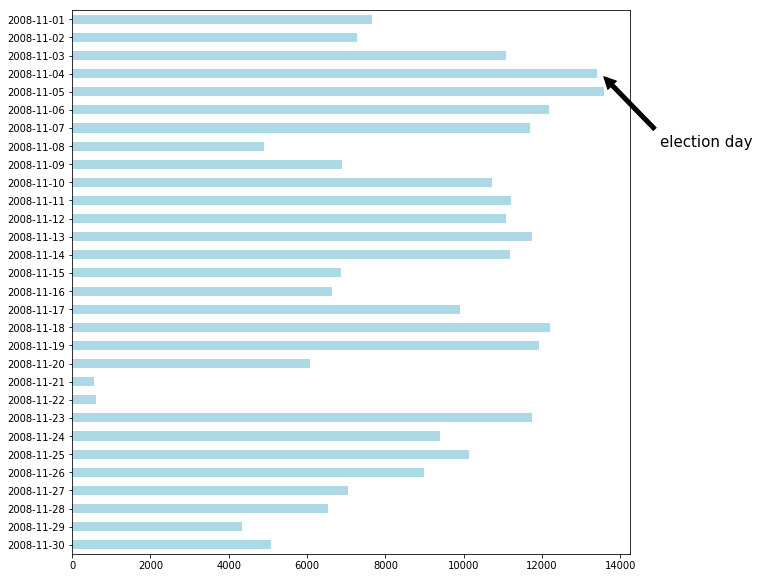

In [13]:
ax = df_2008_us['SQLDATE'].astype(str).value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10), color='lightblue');
        
ax.annotate('election day', xy=(13500, 26), xytext=(15000, 22), size=15,
            arrowprops=dict(facecolor='black', shrink=0.05))
# TODO Annotations to point at 11-04.
# https://matplotlib.org/users/annotations.html

Thus we see a significant uptick in news on and around election day which matches what we would expect. We also do not see any unexpected dates in this 2008 dataframe. Now we look at the 2016 dataframe. The 2016 dataframe was loaded from a CSV labeled for the exact day we are interested in, November 8th, 2016, so this is really just a sanity check on the data.

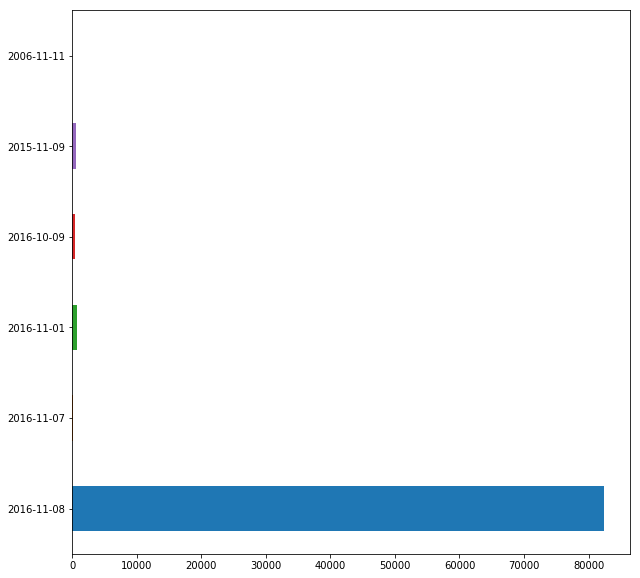

In [14]:
df_2016_us['SQLDATE'].astype(str).value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10));

And it's a good thing we did it! There are other dates floating around in the dataset which appear to be anomalous. There's at least one 2006 date where appears to be a typo, as well as a 2015 date thrown in this dataset. This indicates we should be sure to filter our 2016 dataset for date as well. 

In [15]:
election_day_2008 = np.datetime64('2008-11-04')
df_2008_usel = df_2008_us.loc[df_2008_us['SQLDATE'] == election_day_2008,:].copy()
election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us.loc[df_2016_us['SQLDATE'] == election_day_2016,:].copy()

## AvgTone 

With our data prepared, we can now start looking at the column of interest we set out to explore, AvgTone. First, let's get an idea of the range of values for our dataframes.

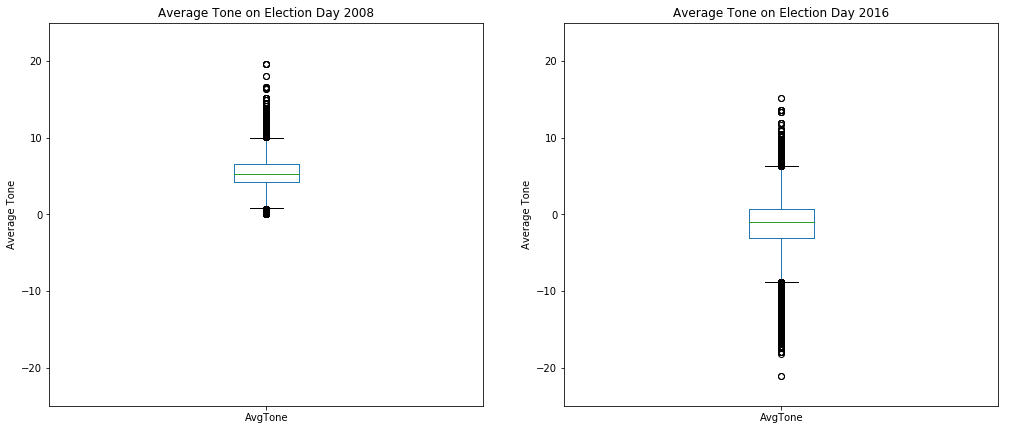

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.tight_layout(pad=5)

plt.subplot(1,2,1)
df_2008_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2008")

plt.subplot(1,2,2)
df_2016_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2016");

We notice right away that the tone of news stories coming out in 2008 was substantially higher and with far fewer variance than what was being seen in 2016.

## AvgTone by State

We can break this down further and attempt to understand the tone of news stories reporting on actions in particular states.  To do this, we'll first have to dig a little deeper into the data and look at the ActionGeo_ADM1Code column which codes more specified location information.

In [17]:
df_2008_usel['ActionGeo_ADM1Code'].unique()

[USDC, USMD, US, USMO, USOR, ..., USRI, USDE, USWI, USAR, USWY]
Length: 53
Categories (53, object): [USDC, USMD, US, USMO, ..., USDE, USWI, USAR, USWY]

We see that the codes for US states are provided in the format of US followed by the 2 letter state code, provided that the event was able to be localized down to the state level. state_dict has already been defined in our GDELT_utils.py to map the codes to the state name. We use it to rename our indices and present the mean AvgTone as grouped by state.

In [18]:
avgtone_2008 = df_2008_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2008_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)
avgtone_2016 = df_2016_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2016_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)

We first show it on a line graph to give a general impression of the difference of AvgTone across the board between the two election years. Then we show a state heatmap to provide a better means of identifying unique states.

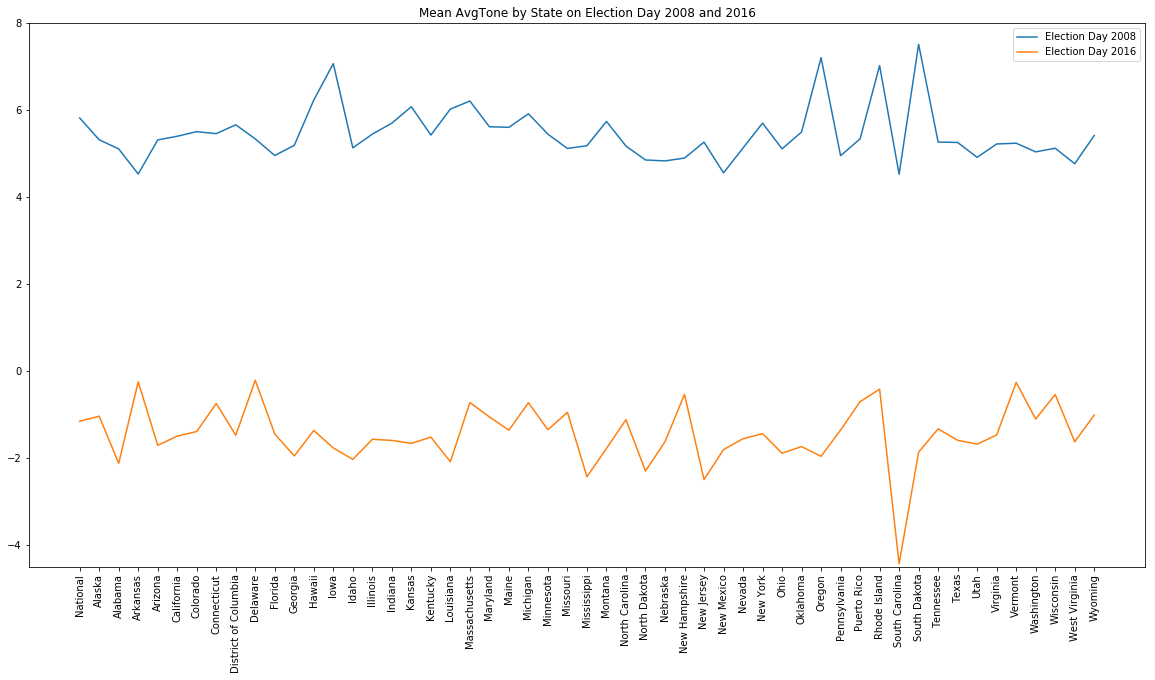

In [19]:
plt.figure(figsize=(20,10))
plt.plot(avgtone_2008, label="Election Day 2008")
plt.plot(avgtone_2016, label="Election Day 2016")
plt.xticks(rotation=90);
plt.ylim(-4.5, 8)
plt.legend()
plt.title("Mean AvgTone by State on Election Day 2008 and 2016");

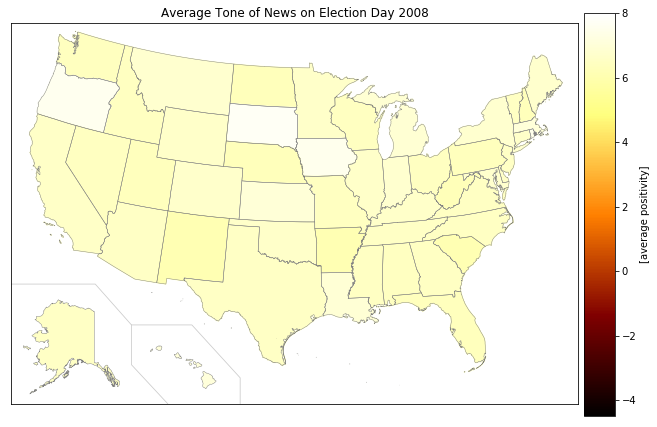

In [20]:
state_heat_map(avgtone_2008, -4.5, 8, 'Average Tone of News on Election Day 2008');

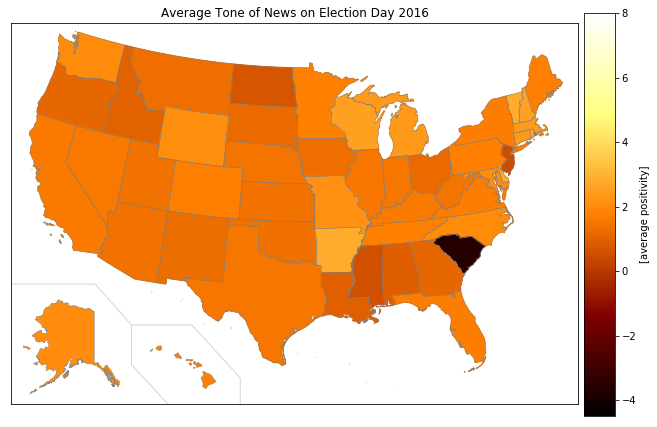

In [21]:
state_heat_map(avgtone_2016, -4.5, 8, 'Average Tone of News on Election Day 2016');

# Conclusion

We set out in this exploration to understand whether we could see a significant different in the average tone of the documents that discuss events taking place in the USA. It seems very likely that there is a statistically significant shift in tone in the 8 years. There are a myriad of things that might be behind this, and it would be worthwhile to dig deeper into the data to see what similarities can be found between the years. 

Were the events simply drastically different or had the tone itself changed due to differences in reporting/media agencies?

Does this have something to do with other known sociological effects that may have happened in the interim 8 years, perhaps shifts in the partisan landscape of media?

It's not at all clear what might cause such a drastic shift, especially since 2008 was in the midst of the last recession, and it should prove interesting to dig deeper into this and find out what happened.

# References and Data Sources

### Data Sources
https://www.gdeltproject.org/data.html

http://data.gdeltproject.org/events/200811.zip
    
http://data.gdeltproject.org/events/20161108.export.CSV.zip

### Data Documentation
http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf

### Code References
https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py
    
https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
    
https://www.dataquest.io/blog/pandas-big-data/ 

# Appendix: AvgTone Boxplot by State

In [22]:
df_2008_usel['ActionGeo_ADM1Code'] = df_2008_usel.loc[:,'ActionGeo_ADM1Code'].cat.remove_unused_categories()
df_2008_usel['ActionGeo_ADM1Code_Readable'] = df_2008_usel.loc[:,'ActionGeo_ADM1Code'].apply(lambda x:state_dict[x])

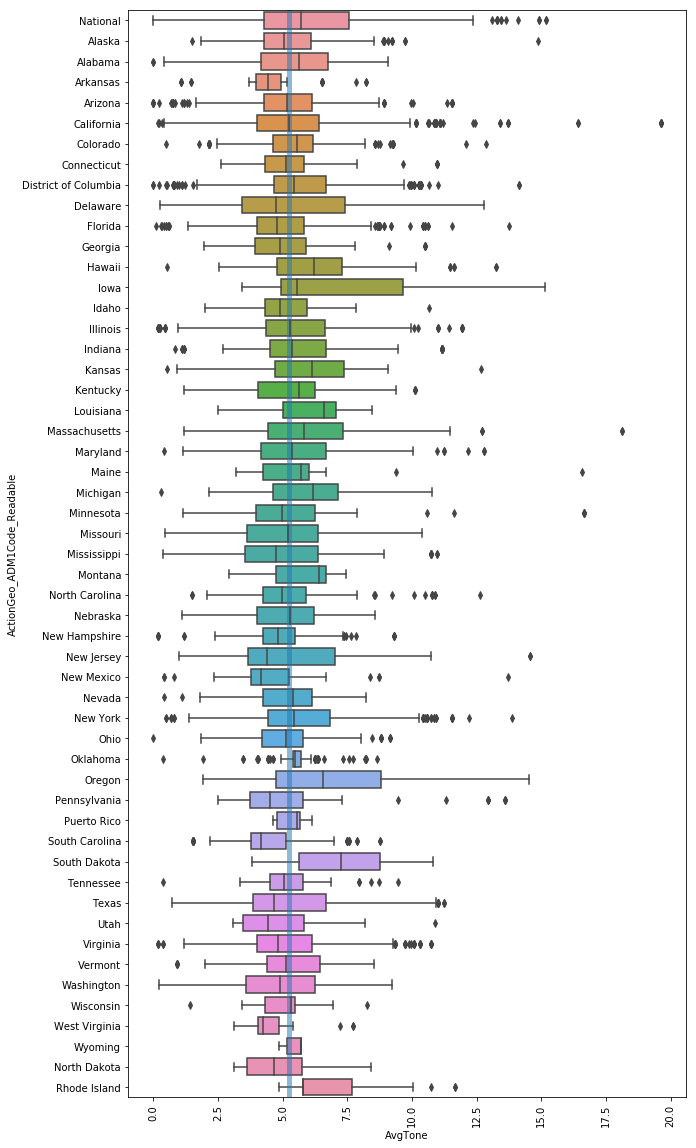

In [23]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df_2008_usel,
            x='AvgTone', y='ActionGeo_ADM1Code_Readable')
plt.axvline(df_2008_usel['AvgTone'].median(), linewidth=5, alpha=0.5)
plt.xticks(rotation=90);

# Appendix: Set CSS Style

In [24]:
# CSS from https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()